<font size="+3">**Unseeded-3 Results**</font>

# Introduction  

In this analysis, we removed all random seeds (and `random_state`), in order to strengthen the generalizability of results obtained with seeds (where the train/validation/test partitions were taken constant).  
We reran the nootebok 3 times, and results are reported in table under "unseeded condition".  
In this notebook, we also removed the extraction of all figures.

# Pre-processing

## Load Libraries

In [30]:
# Libraries for Data Wrangling, Statistics, and Data Visualization

import pyreadr as pr
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, pearsonr 
import statistics # for computing the mode of a variable
import platform   # to print the version of Python and selected libraries

# Libraries for Machine Learning

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import r2_score, make_scorer, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import shap
from skopt import BayesSearchCV # for Bayesian Optimization

## Custom Functions

In [31]:
# The function `extractReliab` is useful to obtain only the alpha value and then round it to 2 numbers

def extractReliab(items):
    """
    Extracts Cronbach's alpha
    
    Parameters:
    - items: specify the items of the target construct to compute ts alpha
    
    Return:
    - float: a float with two decimals
    """
    return float(
        (round(pg.cronbach_alpha(data = items, ci = .99)[0], 2))
        )


# The function `calculate_statistics` is useful to print descriptive statistics, similar to APA style

def calculate_statistics(my_data):    
    """
    Calculates descriptive statistics for the given data frame.

    Parameters:
    - my_data (pandas.DataFrame): Input data frame containing the variables.

    Returns:
    - pandas.DataFrame: Table with calculated statistics.
    """        
    # Calculate skewness and kurtosis for each column
    skw = my_data.apply(skew)
    kurt = my_data.apply(kurtosis)

    # Create a new DataFrame with the desired statistics
    table             = pd.DataFrame()
    table['N']        = my_data.count()
    table['Mean']     = my_data.mean()
    table['SD']       = my_data.std()
    table['Median']   = my_data.median()
    table['Min']      = my_data.min()
    table['Max']      = my_data.max()
    table['Skewness'] = skw
    table['Kurtosis'] = kurt

    # Reset the index to use variable names as rows
    table.reset_index(inplace=True)
    table.rename(columns={'index': 'Variable'}, inplace=True)

    # Round the values to two decimals
    table = table.round(2)

    return table


# The function `r_pvalues` extracts p-values from all pairs of correlations in a dataframe

def r_pvalues(df):
    '''
    Print p-values from a correlation matrix
    
    Parameters:
    - df: a datframe
    
    Returns:
    - a matrix of p-values
    '''
    cols = pd.DataFrame(columns=df.columns)
    p = cols.transpose().join(cols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            p[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return p


# The function `corr_matrix` returns a correlation matrix with colours, values, and no upper triangle

def corr_matrix(my_data, my_dpi=300):
    
    '''
    Print a correlation matrix heatmap, with values inside, and no upper triangle.
   
    Parameters:
     - my_data: (pandas.DataFrame): Input data frame containing the variables.
     - my_dpi: specify dpi (default = 300).
   
    Returns:
     - a matplotlib figure.
    '''
    
    # Compute p-value matrix
    def compute_pvalues(data):
        return data.apply(lambda x: data.apply(lambda y: pearsonr(x, y)[1]))

    # Function to determine significance level
    def significance_asterisks(p_val):
        if p_val < 0.001:
            return '***'
        elif p_val < 0.01:
            return '**'
        elif p_val < 0.05:
            return '*'
        else:
            return ''
    
    fig, ax = plt.subplots(figsize=(6, 6), dpi=my_dpi)
    
    pvalues = compute_pvalues(my_data)
    corr_values = my_data.corr()

    # Mask for upper triangle and for p-values above 0.05
    mask = np.triu(np.ones_like(corr_values, dtype=bool))
    
    # Generate a mask for the significant cells
    significance = pvalues.applymap(significance_asterisks)
    
    # Merge correlation values and significance level
    annotations = corr_values.applymap('{:.2f}'.format) + '\n' + significance

    sns.heatmap(
        corr_values,
        mask=mask,
        vmin=-0.7,
        vmax=0.7,
        cmap=sns.diverging_palette(20, 220, as_cmap=True),
        annot=annotations,
        fmt="s",
        annot_kws={"size": 6}, # sets the font size of the correlation value annotations
        cbar=False             # remove vertical bar (bar with coulurs indicating the size of the correlations)
    )
    plt.xticks(fontsize=7,
               rotation=90) # Rotate x-axis labels by *n* degrees
    plt.yticks(fontsize=7)
    return ax.get_figure()


# The function `overf_check` returns an histogram for overfitting check, using bootstrap as technique and using MAE as metric.
#  It also returns median and 95% confidence intervals for both MAE and R^2, based on bootstrap (with 1000 resamplings)

def overf_check(tuned_model,
                my_seed = 1234,
                title_overfit = '',
                my_dpi = 300,
                print_values=False,
                model_name = ''):
    """
    Test and Visualization of Overfitting.

    Parameters:
    - tuned_model: The tuned model (elastic net, random forest, etc.).
    - my_seed: set the seed (dafault = 1234).
    - title_overfit: title of the histogram.
    - my_dpi: specify `dpi` (default = 300); to print the in notebook, dpi = 100 is suggested.
    - print_values: print or not the values of the histograms (default = False).
    - model_name: the name of the model (e.g., "Elastic Net", "Random Forest") to be printed when `print_values = True`.

    Returns:
    - a matplotlib figure.
    """        
   
    subset_ratio = 0.25
    n_repeats    = 1000

    MAE_train = []
    MAE_test  = []
    R2_train  = []
    R2_test   = []

    n_train = X_train.shape[0]
    n_test  = X_test.shape[0]

    # fix a seed
    np.random.seed(my_seed)

    #repeat 'n_repeats' times
    for i in range(n_repeats):
        
        #select a subset
        idx_train = np.random.choice(n_train, int(subset_ratio*n_train))
        idx_test  = np.random.choice(n_test,  int(subset_ratio*n_test ))

        # Use a scaler for train and test partition
        X_train_ = scaler.fit_transform(X_train[idx_train])
        X_test_  = scaler.transform(X_test[idx_test])
        
        #generate prediction on the subset
        Y_pred_train_ = tuned_model.predict(X_train_)
        Y_pred_test_  =  tuned_model.predict(X_test_)

        #compute (and store) performances on the subset
        ## for MAE
        MAE_train.append(mean_absolute_error(Y_train[idx_train], Y_pred_train_))
        MAE_test.append(mean_absolute_error(Y_test[idx_test], Y_pred_test_))
        ## for R_squared
        R2_train.append(r2_score(Y_train[idx_train], Y_pred_train_))
        R2_test.append(r2_score(Y_test[idx_test], Y_pred_test_))    

    train_median_MAE, train_CI5_MAE, train_CI95_MAE = np.quantile(MAE_train, [0.5, 0.05, 0.95])
    test_median_MAE, test_CI5_MAE, test_CI95_MAE    = np.quantile(MAE_test, [0.5, 0.05, 0.95])
    train_median_r2, train_CI5_r2, train_CI95_r2 = np.quantile(R2_train, [0.5, 0.05, 0.95])
    test_median_r2, test_CI5_r2, test_CI95_r2    = np.quantile(R2_test, [0.5, 0.05, 0.95])    
    
    
    if print_values:
        print(f"MAE train ({model_name}): {train_median_MAE:.3f} [{train_CI5_MAE:.3f}-{train_CI95_MAE:.3f}]")
        print(f"MAE test ({model_name}): {test_median_MAE:.3f} [{test_CI5_MAE:.3f}-{test_CI95_MAE:.3f}]")
        print(f"R^2 train ({model_name}): {train_median_r2:.3f} [{train_CI5_r2:.3f}-{train_CI95_r2:.3f}]")
        print(f"R^2 test ({model_name}): {test_median_r2:.3f} [{test_CI5_r2:.3f}-{test_CI95_r2:.3f}]")

    # Figure (based only on MAE) ------------
    
    ## Create a new figure object
    fig = plt.figure(dpi=my_dpi)  
    
    ## Add the plot elements to the figure
    plt.bar(0, train_median_MAE)
    plt.plot([0,0], [train_CI5_MAE, train_CI95_MAE], 'k')

    plt.bar(1, test_median_MAE)
    plt.plot([1,1], [test_CI5_MAE, test_CI95_MAE], 'k')

    plt.xticks([0,1], ['Train', 'Test'])
    plt.ylabel("Mean Absolute Error (MAE)")
    plt.title(title_overfit)
    
    ## Return the figure object
    return fig

## Set Seed

In [32]:
# np.random.seed(1234)

## Load and Wrangle Dataset  

We specify that most of data cleaning was done in R.  
In what follows, we will just load the cleaned dataset and make some adjustment and EDA 

In [33]:
import warnings

with warnings.catch_warnings(record=True):
    warnings.simplefilter("always")
    my_data = pd.read_excel('../output_t2/my_dataset_t1t2.xlsx', engine="openpyxl")
    
my_data.shape # (rows, columns)

(321, 226)

## Rename Features of Interest

In [34]:
my_data = my_data.rename(
    columns={
        "asc_mat":"ASC_math",
        "asc_ita":"ASC_verb",
        "mot_ester":"Mot_ext",
        "mot_intro":"Mot_introj",
        "mot_ident":"Mot_ident",
        "mot_intr":"Mot_intrin",
        "cont_aut":"Self_est",
        "cap_hope":"PsyCap_hope",
        "cap_resil":"PsyCap_resil",
        "cap_ottim":"PsyCap_optim",
        "eff_scol":"PsyCap_Eff",
        "bfq_openn":"BFQ_openn",
        "bfq_consc":"BFQ_consc",
        "prosoc":"Prosoc",
        "dis_mor":"Moral_dis",
        "qdp_care":"PQT_care",
        "qdp_clar":"PQT_clar",
        "qdp_conf":"PQT_conf",
        "qdp_cons":"PQT_cons",
        "peer_clim":"Peer_clim"
    }
)

## Create a composite score for PsyCap at T1 (`PsyCap`) and T2 (`PsyCap_t2`)

Items for Self-efficacy range from 1 to 4 (instead of from 1 to 5, as it is for the other three PsyCap dimensions).  
Hence, in order to compute the overall composite score for PsyCap at T1 and T2, there is the need for a rescaling.

In [35]:
PsyCap_1a     = my_data[['psycap1', 'psycap2', 'psycap3',
                          'psycap4', 'psycap5', 'psycap6', 'psycap7', 'psycap8',
                          'psycap9', 'psycap10', 'psycap11']].mean(axis = 1)

PsyCap_1b    = 5/4*my_data[['eff1', 'eff2', 'eff3', 'eff4']].mean(axis = 1)

PsyCap_t2a     = my_data[['psycap1_t2', 'psycap2_t2', 'psycap3_t2',
                          'psycap4_t2', 'psycap5_t2', 'psycap6_t2', 'psycap7_t2', 'psycap8_t2',
                          'psycap9_t2', 'psycap10_t2', 'psycap11_t2']].mean(axis = 1)

PsyCap_t2b    = 5/4*my_data[['eff1_t2', 'eff2_t2', 'eff3_t2', 'eff4_t2']].mean(axis = 1)

my_data = my_data.assign(
    PsyCap = 0.5 * (PsyCap_1a + PsyCap_1b),
    PsyCap_t2 = 0.5 * (PsyCap_t2a + PsyCap_t2b),
    )


# Check T1

display(pd.concat([pd.DataFrame(my_data[['psycap1', 'psycap2', 'psycap3',
               'psycap4', 'psycap5', 'psycap6', 'psycap7', 'psycap8',
               'psycap9', 'psycap10', 'psycap11',
               'eff1', 'eff2', 'eff3', 'eff4']]),
                   pd.DataFrame(PsyCap_1a, columns=['PsyCap_1a']),
                   pd.DataFrame(PsyCap_1b, columns=['PsyCap_1b']),
                   pd.DataFrame(my_data[['PsyCap']])], axis=1))

# Check T2

display(pd.concat([pd.DataFrame(my_data[['psycap1_t2', 'psycap2_t2', 'psycap3_t2',
                          'psycap4_t2', 'psycap5_t2', 'psycap6_t2', 'psycap7_t2', 'psycap8_t2',
                          'psycap9_t2', 'psycap10_t2', 'psycap11_t2',
               'eff1_t2', 'eff2_t2', 'eff3_t2', 'eff4_t2']]),
                   pd.DataFrame(PsyCap_t2a, columns=['PsyCap_t2a']),
                   pd.DataFrame(PsyCap_t2b, columns=['PsyCap_t2b']),
                   pd.DataFrame(my_data[['PsyCap_t2']])], axis=1))

,psycap1,psycap2,psycap3,psycap4,psycap5,psycap6,psycap7,psycap8,psycap9,psycap10,psycap11,eff1,eff2,eff3,eff4,PsyCap_1a,PsyCap_1b,PsyCap
0,5,4,3,4,2,3,5,4,3,5,3,4,3,4,3,3.727273,4.3750,4.051136
1,5,5,5,4,4,4,5,4,4,5,4,4,3,3,3,4.454545,4.0625,4.258523
2,3,1,2,4,3,3,3,4,1,3,1,2,2,3,3,2.545455,3.1250,2.835227
3,4,3,2,4,2,5,5,4,3,5,4,4,3,3,4,3.727273,4.3750,4.051136
4,5,5,5,5,5,5,5,5,5,5,5,3,3,3,3,5.000000,3.7500,4.375000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,4,2,4,4,3,4,4,4,1,5,2,3,4,2,4,3.363636,4.0625,3.713068
317,3,2,1,3,1,2,4,3,2,4,4,2,2,3,3,2.636364,3.1250,2.880682
318,5,5,5,4,3,4,5,4,3,3,4,3,3,3,3,4.090909,3.7500,3.920455
319,4,4,3,4,4,3,4,4,3,4,4,3,3,3,3,3.727273,3.7500,3.738636


,psycap1_t2,psycap2_t2,psycap3_t2,psycap4_t2,psycap5_t2,psycap6_t2,psycap7_t2,psycap8_t2,psycap9_t2,psycap10_t2,psycap11_t2,eff1_t2,eff2_t2,eff3_t2,eff4_t2,PsyCap_t2a,PsyCap_t2b,PsyCap_t2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,5.0,4.0,4.0,3.0,4.0,5.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,4.000000,3.7500,3.875000
2,1.0,1.0,1.0,4.0,2.0,1.0,2.0,1.0,1.0,3.0,1.0,2.0,2.0,2.0,2.0,1.636364,2.5000,2.068182
3,5.0,4.0,3.0,2.0,1.0,1.0,1.0,2.0,3.0,5.0,3.0,4.0,4.0,4.0,4.0,2.727273,5.0000,3.863636
4,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,3.0,3.0,3.0,3.0,4.090909,3.7500,3.920455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,1.0,1.0,1.0,4.0,1.0,4.0,3.0,4.0,1.0,1.0,4.0,3.0,4.0,3.0,3.0,2.272727,4.0625,3.167614
317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318,5.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,4.000000,3.7500,3.875000
319,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,4.0,2.0,3.0,2.0,3.0,3.0,3.636364,3.4375,3.536932


## Drop NA and Check Sample Size

In [36]:
# Drop Rows with NA in (future) targets columns

my_data = my_data.dropna(subset=['cap_hope_t2',
              'cap_resil_t2',
              'cap_ottim_t2',
              'eff_scol_t2',
              'PsyCap_t2']) 

my_data.shape ## my_data drops from 321 to 283 subjects

(283, 228)

## Density Plot for PsyCap at T2

Text(0.5, 0, 'Psychological Capital T2')

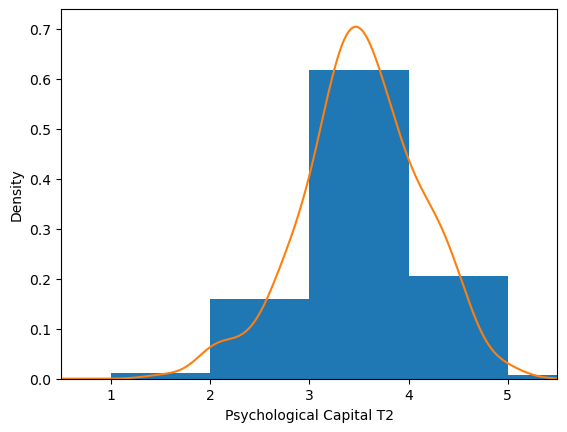

In [37]:
ax = my_data['PsyCap_t2'].plot.hist(density=True, xlim=[0.5,5.5], bins=range(1,12))
my_data['PsyCap_t2'].plot.density(ax=ax)
ax.set_xlabel('Psychological Capital T2')

## Stats for PsyCap at T2

In [38]:
psycap_t2_stats = pd.DataFrame(
    {'Statistic': ['Mean', 'Median', 'Mode', 'Std Deviation', 'Skewness', 'Kurtosis'],
     'Value': [np.mean(my_data['PsyCap_t2']),
               np.median(my_data['PsyCap_t2']),
               statistics.mode(my_data['PsyCap_t2']), # note that mode is not coputed with `np.` but with `statistics.`
               np.std(my_data['PsyCap_t2']),
               skew(my_data['PsyCap_t2']),
               kurtosis(my_data['PsyCap_t2'])]}
)

round(psycap_t2_stats, 2)

,Statistic,Value
0,Mean,3.52
1,Median,3.50
2,Mode,3.88
3,Std Deviation,0.60
4,Skewness,-0.27
5,Kurtosis,0.23


## Select Features for Exploring Descriptive Statistics and Correlations

In [39]:
# Select only study variables, to investigate descr stats and correlations

my_data_psycap_var = my_data[[
    'ASC_math',      # Math Self-concept
    'ASC_verb',      # Verbal (Italian) Self-concept
    'Mot_ext',       # External Motivation
    'Mot_introj',    # Introjected Motivation
    'Mot_ident',     # Identified Motivation
    'Mot_intrin',    # Intrinsic Motivation
    'Self_est',      # Academic contingencies of Self-esteem
    'BFQ_openn',     # Openness to experience
    'BFQ_consc',     # Conscientiousness
    'Prosoc',        # Prosociality
    'Moral_dis',     # Moral Disengagement
    'PQT_care',      # Perceived Quality of Teaching [Qualità della didattica percepita] - Care
    'PQT_clar',      # Perceived Quality of Teaching [Qualità della didattica percepita] - Clarify
    'PQT_conf',      # Perceived Quality of Teaching [Qualità della didattica percepita] - Confere
    'PQT_cons',      # Perceived Quality of Teaching [Qualità della didattica percepita] - Consolidate
    'Peer_clim',     # Peer climate
    'PsyCap',        # Psychological Capital
    'PsyCap_t2'      # Psychological Capital at T2
]]

## Descriptive Statistics

In [40]:
calculate_statistics(my_data_psycap_var)

,Variable,N,Mean,SD,Median,Min,Max,Skewness,Kurtosis
0,ASC_math,283,2.63,0.81,2.75,1.00,4.00,-0.15,-0.79
1,ASC_verb,283,2.76,0.66,2.75,1.00,4.00,-0.25,-0.29
2,Mot_ext,283,2.33,0.81,2.33,1.00,4.00,0.15,-0.75
3,Mot_introj,283,2.40,0.77,2.50,1.00,4.00,0.14,-0.54
4,Mot_ident,283,3.50,0.56,3.50,1.00,4.00,-1.21,1.82
5,Mot_intrin,283,2.58,0.76,2.50,1.00,4.00,-0.13,-0.50
6,Self_est,283,4.59,1.06,4.80,1.00,6.80,-0.67,0.51
7,BFQ_openn,283,3.42,0.76,3.50,1.25,5.00,-0.26,-0.24
8,BFQ_consc,283,3.41,0.76,3.50,1.33,5.00,-0.24,-0.50
9,Prosoc,283,1.54,0.40,1.60,0.20,2.00,-0.77,-0.08


## Correlations

In [41]:
cor_psycap = round((my_data_psycap_var.corr()) , 2)

# Set the upper triangle (excluding the diagonal) to NaN values
cor_psycap = cor_psycap.mask(np.triu(np.ones(cor_psycap.shape), k=1).astype(bool))

# Replace all NaN values with empty cells
cor_psycap = cor_psycap.replace(np.nan, '', regex=True)

# Print
cor_psycap

,ASC_math,ASC_verb,Mot_ext,Mot_introj,Mot_ident,Mot_intrin,Self_est,BFQ_openn,BFQ_consc,Prosoc,Moral_dis,PQT_care,PQT_clar,PQT_conf,PQT_cons,Peer_clim,PsyCap,PsyCap_t2
ASC_math,1.00,,,,,,,,,,,,,,,,,
ASC_verb,0.11,1.0,,,,,,,,,,,,,,,,
Mot_ext,-0.04,-0.1,1.0,,,,,,,,,,,,,,,
Mot_introj,-0.03,0.08,0.28,1.0,,,,,,,,,,,,,,
Mot_ident,0.20,0.22,-0.01,0.38,1.0,,,,,,,,,,,,,
Mot_intrin,0.17,0.3,-0.12,0.25,0.58,1.0,,,,,,,,,,,,
Self_est,0.18,0.27,0.05,0.5,0.49,0.45,1.0,,,,,,,,,,,
BFQ_openn,0.55,0.39,-0.1,0.1,0.33,0.41,0.26,1.0,,,,,,,,,,
BFQ_consc,0.40,0.4,-0.13,0.27,0.51,0.59,0.37,0.6,1.0,,,,,,,,,
Prosoc,0.03,0.14,-0.04,0.13,0.26,0.25,0.16,0.22,0.28,1.0,,,,,,,,


In [42]:
# print p-values

r_pvalues(df=my_data_psycap_var)

,ASC_math,ASC_verb,Mot_ext,Mot_introj,Mot_ident,Mot_intrin,Self_est,BFQ_openn,BFQ_consc,Prosoc,Moral_dis,PQT_care,PQT_clar,PQT_conf,PQT_cons,Peer_clim,PsyCap,PsyCap_t2
ASC_math,0.0,0.067,0.4671,0.669,0.0006,0.0042,0.0021,0.0,0.0,0.6554,0.6292,0.0319,0.1721,0.0456,0.0841,0.0561,0.0,0.0
ASC_verb,0.067,0.0,0.0867,0.1609,0.0002,0.0,0.0,0.0,0.0,0.0158,0.0864,0.5361,0.4468,0.0072,0.1722,0.2454,0.0,0.0
Mot_ext,0.4671,0.0867,0.0,0.0,0.8448,0.043,0.3867,0.1009,0.032,0.5567,0.0,0.5204,0.0045,0.0852,0.0326,0.1219,0.0044,0.014
Mot_introj,0.669,0.1609,0.0,0.0,0.0,0.0,0.0,0.1032,0.0,0.0301,0.7841,0.0919,0.6347,0.0612,0.121,0.0338,0.0826,0.086
Mot_ident,0.0006,0.0002,0.8448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0104,0.0,0.0,0.0,0.0,0.7417,0.0,0.0
Mot_intrin,0.0042,0.0,0.043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0035,0.0,0.0,0.0,0.0,0.0078,0.0,0.0
Self_est,0.0021,0.0,0.3867,0.0,0.0,0.0,0.0,0.0,0.0,0.0062,0.0781,0.0098,0.024,0.0001,0.0019,0.5238,0.0,0.0
BFQ_openn,0.0,0.0,0.1009,0.1032,0.0,0.0,0.0,0.0,0.0,0.0002,0.0392,0.1296,0.0568,0.0019,0.0046,0.0069,0.0,0.0
BFQ_consc,0.0,0.0,0.032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008,0.0001,0.0001,0.0,0.0,0.0038,0.0,0.0
Prosoc,0.6554,0.0158,0.5567,0.0301,0.0,0.0,0.0062,0.0002,0.0,0.0,0.0386,0.0,0.0004,0.0,0.0,0.0,0.0,0.0002


## Enhance Data Visualization of Correlations

Text(0.5, 1.0, 'Correlation matrix for the whole sample ($\\it{N}$ = 283)')

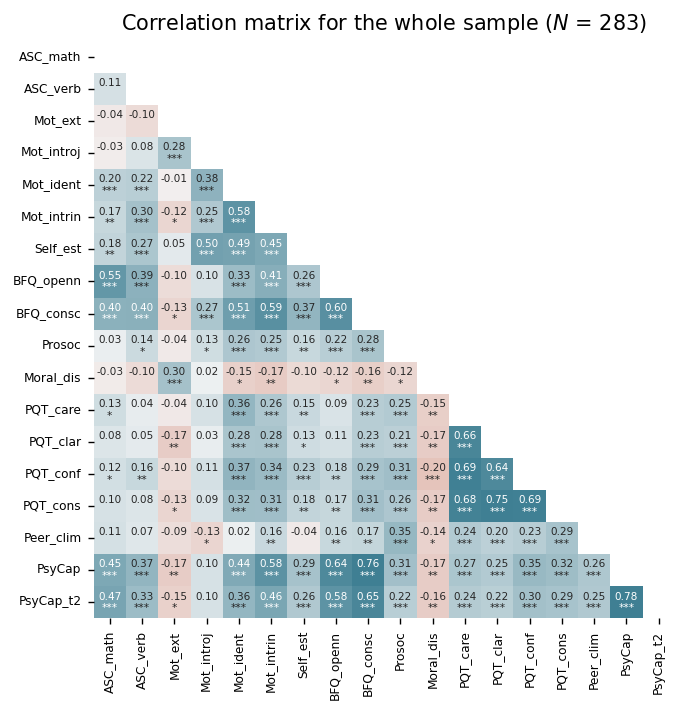

In [43]:
corr_matrix(my_data_psycap_var, my_dpi=125)
plt.title('Correlation matrix for the whole sample ($\it{N}$ = 283)')

# Export the figure in .png with 300 dpi
#plt.savefig('../figs_Python/corr_wholeSample.png', dpi=300)

# Note: matrix correlations for train and test data separated are reported in another section

## Reliability

In [44]:
# Reliability -------------------------------------------------------

Reliability_data = pd.DataFrame(
    {# Features
    'ASC_math ': [extractReliab(items=my_data[['ascm1', 'ascm2', 'ascm3', 'ascm4']])],
    'ASC_verb ': [extractReliab(items=my_data[['asci1', 'asci2', 'asci3', 'asci4']])],
    'Mot_ext  ': [extractReliab(items=my_data[['mot1', 'mot5', 'mot9']])],
    'Mot_introj': [extractReliab(items=my_data[['mot2', 'mot6']])],
    'Mot_ident': [extractReliab(items=my_data[['mot3', 'mot7']])],
    'Mot_intrin': [extractReliab(items=my_data[['mot4', 'mot8']])],
    'Self_est ': [extractReliab(items=my_data[['csw1_r', 'csw2', 'csw3', 'csw4', 'csw5']])],
    'BFQ_openn': [extractReliab(items=my_data[['open1', 'open2', 'open3', 'open4']])],
    'BFQ_consc': [extractReliab(items=my_data[['cons1', 'cons2', 'cons3', 'cons4', 'cons5', 'cons6']])],
    'Prosoc   ': [extractReliab(items=my_data[['pros1', 'pros2', 'pros3', 'pros4', 'pros5']])],
    'Moral_dis': [extractReliab(items=my_data[['dismor1', 'dismor2', 'dismor3']])],
    'PQT_care ': [extractReliab(items=my_data[['qdp1', 'qdp2', 'qdp3']])],
    'PQT_clar ': [extractReliab(items=my_data[['qdp4', 'qdp5', 'qdp6']])],
    'PQT_conf ': [extractReliab(items=my_data[['qdp7', 'qdp8', 'qdp9']])],
    'PQT_cons ': [extractReliab(items=my_data[['qdp10', 'qdp11', 'qdp12', 'qdp13']])],
    'Peer_clim': [extractReliab(items=my_data[['clim1', 'clim2', 'clim3', 'clim4_r']])],

     # PsyCap   
     'Hope_T1': [extractReliab(items=my_data[['psycap1', 'psycap2', 'psycap3']])],
     'Hope_T2': [extractReliab(items=my_data[['psycap1_t2', 'psycap2_t2', 'psycap3_t2']])],
     'Resilience_T1': [extractReliab(items=my_data[['psycap4', 'psycap5', 'psycap6', 'psycap7', 'psycap8']])],
     'Resilience_T2': [extractReliab(items=my_data[['psycap4_t2', 'psycap5_t2', 'psycap6_t2', 'psycap7_t2', 'psycap8_t2']])],
     'Optimism_T1': [extractReliab(items=my_data[['psycap9', 'psycap10', 'psycap11']])],
     'Optimism_T2': [extractReliab(items=my_data[['psycap9_t2', 'psycap10_t2', 'psycap11_t2']])],
     'Self_efficacy_t1': [extractReliab(items=my_data[['eff1', 'eff2', 'eff3', 'eff4']])],
     'Self_efficacy_t2': [extractReliab(items=my_data[['eff1_t2', 'eff2_t2', 'eff3_t2', 'eff4_t2']])],
     'PsyCap_T1': [extractReliab(items=my_data[['psycap1', 'psycap2', 'psycap3',
                                               'psycap4', 'psycap5', 'psycap6', 'psycap7', 'psycap8',
                                               'psycap9', 'psycap10', 'psycap11',
                                               'eff1', 'eff2', 'eff3', 'eff4']])],
     'PsyCap_T2': [extractReliab(items=my_data[['psycap1_t2', 'psycap2_t2', 'psycap3_t2',
                                               'psycap4_t2', 'psycap5_t2', 'psycap6_t2', 'psycap7_t2', 'psycap8_t2',
                                               'psycap9_t2', 'psycap10_t2', 'psycap11_t2',
                                               'eff1_t2', 'eff2_t2', 'eff3_t2', 'eff4_t2']])]
        }
    ).melt().rename(columns={"variable": "Variable", "value":  r'Cronbach $\alpha$'})

Reliability_data

,Variable,Cronbach $\alpha$
0,ASC_math,0.89
1,ASC_verb,0.86
2,Mot_ext,0.72
3,Mot_introj,0.61
4,Mot_ident,0.70
5,Mot_intrin,0.76
6,Self_est,0.67
7,BFQ_openn,0.78
8,BFQ_consc,0.82
9,Prosoc,0.73


# Prepare Features

## Select Features and Target

In [45]:
# Specify Features and Target(s)

my_features = [
'ASC_math',
'ASC_verb',
'Mot_ext',
'Mot_introj',
'Mot_ident',
'Mot_intrin',
'Self_est',
'BFQ_openn',
'BFQ_consc',
'Prosoc',
'Moral_dis',
'PQT_care',
'PQT_clar',
'PQT_conf',
'PQT_cons',
'Peer_clim',
'PsyCap'
]

my_targets = ['cap_hope_t2',
              'cap_resil_t2',
              'cap_ottim_t2',
              'eff_scol_t2',
              'PsyCap_t2']



# Extract Features and Target ----------------------------------------------

X = my_data[my_features].values
Y = my_data[my_targets[4]].values # [4] refers to PsyCap_t2

## Train and Test Data

In [46]:
# Train / Test split ------------------------------------------------------

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25)

print(X_train.shape)  # features (X) for training data
print(X_test.shape)   # features (X) for test data
print(Y_train.shape)  # target/output (Y) for training data
print(Y_test.shape)   # target/output (Y) for test data

(212, 17)
(71, 17)
(212,)
(71,)


## Descriptive Statistics for Train and Test Data

In [47]:
# Build train partition
train_partition = np.concatenate(
    (X_train,
     Y_train.reshape(-1, 1)), # Reshape Y_train to have 2 dimensions
     axis=1
)

## Convert to Pandas dataframe
train_partition = pd.DataFrame(
    train_partition,
    columns=my_data_psycap_var.columns
)

# Build test partition
test_partition = np.concatenate(
    (X_test,
     Y_test.reshape(-1, 1)), # Reshape Y_test to have 2 dimensions
     axis=1)

## Convert to Pandas dataframe
test_partition = pd.DataFrame(
    test_partition,
    columns=my_data_psycap_var.columns
)

In [48]:
# TRAIN partition

print("TRAIN partition")
calculate_statistics(my_data=train_partition)

TRAIN partition


,Variable,N,Mean,SD,Median,Min,Max,Skewness,Kurtosis
0,ASC_math,212,2.65,0.81,2.75,1.00,4.00,-0.20,-0.75
1,ASC_verb,212,2.78,0.68,2.75,1.00,4.00,-0.29,-0.30
2,Mot_ext,212,2.36,0.80,2.33,1.00,4.00,0.18,-0.69
3,Mot_introj,212,2.41,0.77,2.50,1.00,4.00,0.16,-0.58
4,Mot_ident,212,3.50,0.58,3.50,1.00,4.00,-1.28,2.04
5,Mot_intrin,212,2.59,0.77,2.50,1.00,4.00,-0.12,-0.62
6,Self_est,212,4.60,1.04,4.80,1.00,6.80,-0.78,0.68
7,BFQ_openn,212,3.44,0.75,3.50,1.25,5.00,-0.36,0.04
8,BFQ_consc,212,3.40,0.78,3.33,1.33,5.00,-0.13,-0.59
9,Prosoc,212,1.56,0.38,1.60,0.20,2.00,-0.76,0.04


In [49]:
# TEST partition

print("TEST partition")
calculate_statistics(my_data=test_partition)

TEST partition


,Variable,N,Mean,SD,Median,Min,Max,Skewness,Kurtosis
0,ASC_math,71,2.56,0.83,2.50,1.00,4.00,-0.01,-0.85
1,ASC_verb,71,2.70,0.61,2.75,1.25,4.00,-0.11,-0.24
2,Mot_ext,71,2.23,0.82,2.33,1.00,4.00,0.07,-1.00
3,Mot_introj,71,2.40,0.77,2.50,1.00,4.00,0.10,-0.43
4,Mot_ident,71,3.51,0.51,3.50,2.00,4.00,-0.84,0.26
5,Mot_intrin,71,2.55,0.73,2.50,1.00,4.00,-0.17,-0.09
6,Self_est,71,4.59,1.10,4.60,1.60,6.60,-0.41,0.08
7,BFQ_openn,71,3.39,0.77,3.50,1.75,4.75,0.02,-0.95
8,BFQ_consc,71,3.42,0.73,3.50,1.50,4.67,-0.63,-0.12
9,Prosoc,71,1.50,0.44,1.60,0.40,2.00,-0.71,-0.48


## Correlations for Train and Test Data

In [50]:
%%capture
# avoid to print output

train_corr = corr_matrix(train_partition)
plt.title('Train Partition ($\it{n}$ = 212)')

test_corr=corr_matrix(test_partition)
plt.title('Test Partition ($\it{n}$ = 71)')

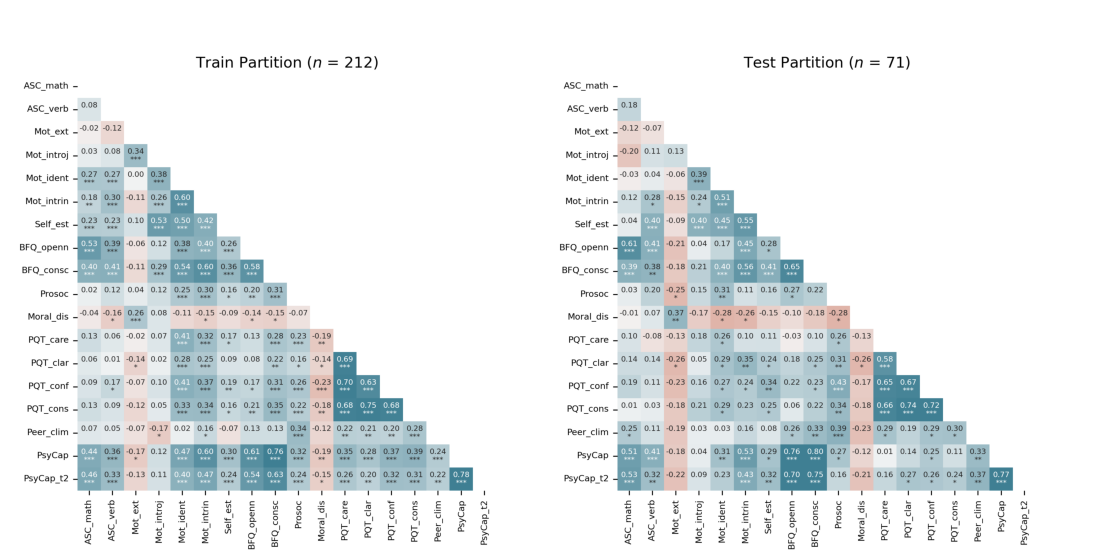

In [51]:
# Merge the above two correlation matrices

# Extract the Axes objects from train_corr and test_corr
ax1 = train_corr.axes[0]
ax2 = test_corr.axes[0]

# Create a new figure with a horizontal layout
fig_merged = plt.figure(figsize=(12, 6))

# Add the first Axes to the left side with adjusted position and size
ax1_new = fig_merged.add_axes([0, 0, 0.45, 1])  # [left, bottom, width, height]
ax1_new.axis('off')

# Render the contents of ax1 as an image
train_corr.canvas.draw()
image_data1 = np.frombuffer(train_corr.canvas.tostring_rgb(), dtype=np.uint8)
image_data1 = image_data1.reshape(train_corr.canvas.get_width_height()[::-1] + (3,))
ax1_new.imshow(image_data1)

# Add the second Axes to the right side with adjusted position and size
ax2_new = fig_merged.add_axes([0.45, 0, 0.45, 1])
ax2_new.axis('off')

# Render the contents of ax2 as an image
test_corr.canvas.draw()
image_data2 = np.frombuffer(test_corr.canvas.tostring_rgb(), dtype=np.uint8)
image_data2 = image_data2.reshape(test_corr.canvas.get_width_height()[::-1] + (3,))
ax2_new.imshow(image_data2)

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0)

# Export the figure in .png with 300 dpi
# plt.savefig('../figs_Python/corr_both.png', dpi=300)

# Display the merged Figure
plt.show()

## Normalization

In [52]:
# Normalization of the features for training data (`fit_transform`),
#  then apply the parameters to test data (`transform`)

scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)


# Check that Means and SD are ~0 and ~1 for training data (they could be slightly different for test data)

print("TRAIN")
print(round(pd.DataFrame(X_train).describe(), 3))
print("TEST")
print(round(pd.DataFrame(X_test).describe(), 3))

TRAIN
            0        1        2        3        4        5        6        7   \
count  212.000  212.000  212.000  212.000  212.000  212.000  212.000  212.000   
mean     0.000    0.000   -0.000    0.000   -0.000   -0.000   -0.000   -0.000   
std      1.002    1.002    1.002    1.002    1.002    1.002    1.002    1.002   
min     -2.057   -2.608   -1.707   -1.823   -4.293   -2.058   -3.456   -2.904   
25%     -0.813   -0.407   -0.870   -0.526   -0.855   -0.761   -0.620   -0.580   
50%      0.120   -0.040   -0.034    0.122    0.004   -0.113    0.197    0.085   
75%      0.742    0.694    0.803    0.771    0.864    0.535    0.774    0.749   
max      1.675    1.795    2.058    2.067    0.864    1.832    2.119    2.077   

            8        9        10       11       12       13       14       15  \
count  212.000  212.000  212.000  212.000  212.000  212.000  212.000  212.000   
mean    -0.000   -0.000    0.000    0.000    0.000    0.000    0.000    0.000   
std      1.002    1.0

# Machine Learning

## Elastic Net

### Optimization (hyperparameter tuning) with *k*-fold cross-validation

In [53]:
# Try several k (2, 5, 8, 10), and store hyperparameters from the best one 

# Parameters
elastic_r_parameter = {
    'alpha': [0.01, 0.025, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.07, 0.10,
              0.15, 0.20, 0.30, 0.40, 0.50, 0.60, 0.80, 1.0, 5.0, 10.0, 25.0,
              50.0, 75.0, 100.0],
    'l1_ratio': [0.25, 0.50, 0.60, 0.70, 0.75, 0.80, 0.85, 1]  # l1_ratio = 1 -> LASSO, l1_ratio = 0 -> Ridge
}

# List of k values
k_values = [2, 8, 10, 5]

# Store results
results = {}

# Loop through each k value
for k in k_values:
    elastic_r_grid_search = GridSearchCV(ElasticNet(max_iter=400000),
                                         elastic_r_parameter,
                                         cv=k)
    elastic_r_grid_search.fit(X_train, Y_train)

    # Store best score and hyperparameters for this k value
    results[k] = {
        'score': elastic_r_grid_search.best_score_,
        'params': elastic_r_grid_search.best_params_
    }

    # Display the results
    print(f'Best score (k = {k}):', results[k]['score'])
    print(f'Best hyperparameters (k = {k}):', results[k]['params'])
    print('-'*40)

# Now, you can access the results for any k value easily from the results dictionary
best_k = max(results, key=lambda k: results[k]['score'])
print(f"Best overall k: {best_k}, Score: {results[best_k]['score']}, Params: {results[best_k]['params']}")

Best score (k = 2): 0.5892459440036061
Best hyperparameters (k = 2): {'alpha': 0.035, 'l1_ratio': 1}
----------------------------------------
Best score (k = 8): 0.5532159566170436
Best hyperparameters (k = 8): {'alpha': 0.045, 'l1_ratio': 0.5}
----------------------------------------
Best score (k = 10): 0.5362883649689195
Best hyperparameters (k = 10): {'alpha': 0.07, 'l1_ratio': 0.6}
----------------------------------------
Best score (k = 5): 0.6028083445888182
Best hyperparameters (k = 5): {'alpha': 0.025, 'l1_ratio': 1}
----------------------------------------
Best overall k: 5, Score: 0.6028083445888182, Params: {'alpha': 0.025, 'l1_ratio': 1}


In [54]:
# elastic_r_grid_search.cv_results_['params'] # See all the combinations of hyperparameters

# type(elastic_r_grid_search.cv_results_)     # This is a dictionary, so below we tranform it in a pandas data frame

pd.DataFrame.from_dict(elastic_r_grid_search.cv_results_) # Inspect column `mean_test_score`, in order to manually verify the presence of
                                                          #   significant excursions on the whole range
                                                          #   of maximum values of best scores obtained by changing the hyperparameters
    
# Extract only summary stats from `mean_test_score`   
print(
    pd.DataFrame.from_dict(
        elastic_r_grid_search.cv_results_
    )['mean_test_score'].describe()
)

count    192.000000
mean       0.330125
std        0.291080
min       -0.045043
25%       -0.045043
50%        0.514571
75%        0.597175
max        0.602808
Name: mean_test_score, dtype: float64


### Train (fit) model and run prediction on train and test data

In [55]:
# Add specified hyperparameters
elastic_tuned = ElasticNet(alpha=0.025, l1_ratio=1)   # Hypeparameters from the 5-fold cross-validation

# Training
elastic_tuned.fit(X_train, Y_train)

# Prediction on train set (useful to subsequently check overfitting)
predict_elNet_tuned_train = elastic_tuned.predict(X_train)

# Prediction on test set
predict_elNet_tuned_test = elastic_tuned.predict(X_test)

### Visualization of Observed vs. Predicted Values

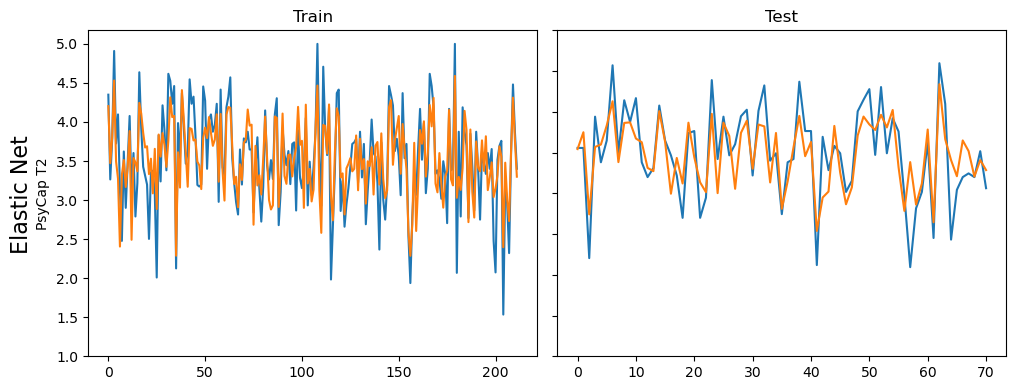

In [56]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first subplot
ax1.plot(Y_train)
ax1.plot(predict_elNet_tuned_train)
ax1.set_title("Train")
#ax1.set_xlabel("Participant")
ax1.set_ylabel("PsyCap T2")
ax1.set_yticks(np.arange(1, 5.5, 0.5))
ax1.set_yticklabels([str(x) for x in np.arange(1, 5.5, 0.5)])
#ax1.legend(['observed', 'predicted'])

# Plot the second subplot
ax2.plot(Y_test)
ax2.plot(predict_elNet_tuned_test)
ax2.set_title("Test")
#ax2.set_xlabel("Participant")
#ax2.set_ylabel("PsyCap T2")
ax2.set_yticks(np.arange(1, 5.5, 0.5))
#ax2.set_yticklabels([str(x) for x in np.arange(1, 5.5, 0.5)])
ax2.set_yticklabels("")
#ax2.legend(['Observed', 'Predicted'], loc='lower right') # Add legend with labels and set location to lower right

# Set a common title for the figure
#fig.suptitle("Prediction for Elastic Net")

# Adjust the spacing between subplots
plt.tight_layout()

# Add a vertical suptitle before the y-axis
fig.text(0, 0.5, "Elastic Net", va='center', ha='center', rotation='vertical', fontsize=16)

# Store the figure in a variable
pred_obser_values_elNet = fig

# Show the figure
plt.show()

### Performance

In [57]:
# Compute MAE for the training set (useful to subsequently check overfitting)

mae_elast_net_train = mean_absolute_error(Y_train, predict_elNet_tuned_train)
print(f"MAE for train set (Elastic Net): {mae_elast_net_train:.3f}")

# Compute MAE for test set

mae_elast_net_test = mean_absolute_error(Y_test, predict_elNet_tuned_test)
print(f"MAE for test set (Elastic Net): {mae_elast_net_test:.3f}")


# Compute R^2 for train set (useful to subsequently check overfitting)

r2_elast_net_train = r2_score(Y_train, predict_elNet_tuned_train)
print(f"R^2 for train set (Elastic Net): {r2_elast_net_train:.3f}")

# Compute R^2 for test set

r2_elast_net_test = r2_score(Y_test, predict_elNet_tuned_test)
print(f"R^2 for test set (Elastic Net): {r2_elast_net_test:.3f}")

MAE for train set (Elastic Net): 0.292
MAE for test set (Elastic Net): 0.274
R^2 for train set (Elastic Net): 0.634
R^2 for test set (Elastic Net): 0.615


### Check overfitting (evaluating MAE) with a Bootstrap approach

MAE train (Elastic Net): 0.295 [0.248-0.353]
MAE test (Elastic Net): 0.272 [0.195-0.378]
R^2 train (Elastic Net): 0.614 [0.442-0.715]
R^2 test (Elastic Net): 0.584 [0.175-0.789]
Figure(640x480)


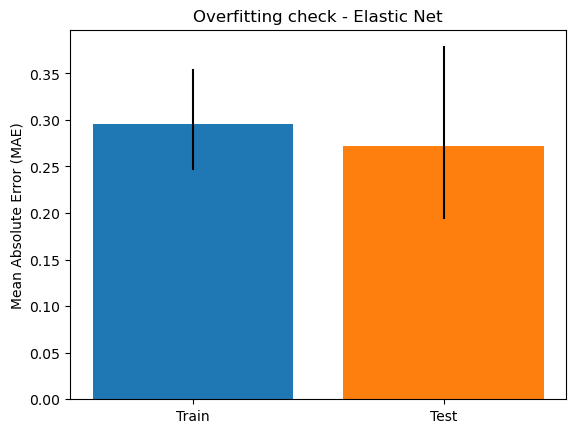

In [58]:
print(
    overf_check(elastic_tuned,
                title_overfit = 'Overfitting check - Elastic Net',
                my_dpi = 100,
                print_values=True,
                model_name= 'Elastic Net')
)

### Feature Importance

In [59]:
# Print intercepts and beta values

# print(f'b0 (estimated): {elastic_tuned.intercept_}')
# print(f'B (estimated): {elastic_tuned.coef_}')

pd.DataFrame(
        {
            'Features': my_features,
            'Parameters': elastic_tuned.coef_}
    ).append(
        {
            'Features':'Intercept',
            'Parameters': elastic_tuned.intercept_
        }, ignore_index=True
    ).round(3)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,Features,Parameters
0,ASC_math,0.065
1,ASC_verb,0.021
2,Mot_ext,-0.000
3,Mot_introj,0.000
4,Mot_ident,0.000
5,Mot_intrin,0.000
6,Self_est,-0.000
7,BFQ_openn,0.013
8,BFQ_consc,0.013
9,Prosoc,0.000


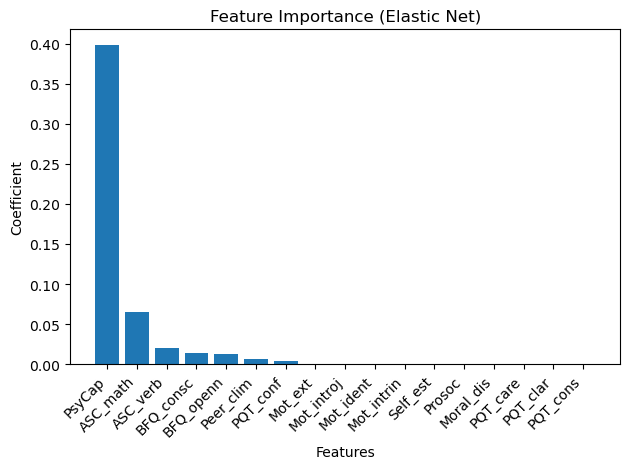

In [60]:
# Visualization of feature importance

coef = elastic_tuned.coef_
df_coef = pd.DataFrame({'feature': my_features, 'coef': coef})
df_coef = df_coef.sort_values('coef', ascending=False)
plt.bar(df_coef['feature'], df_coef['coef'])
plt.xticks(rotation=45, ha='right')
plt.title("Feature Importance (Elastic Net)")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.tight_layout()
plt.show()

### SHAP values

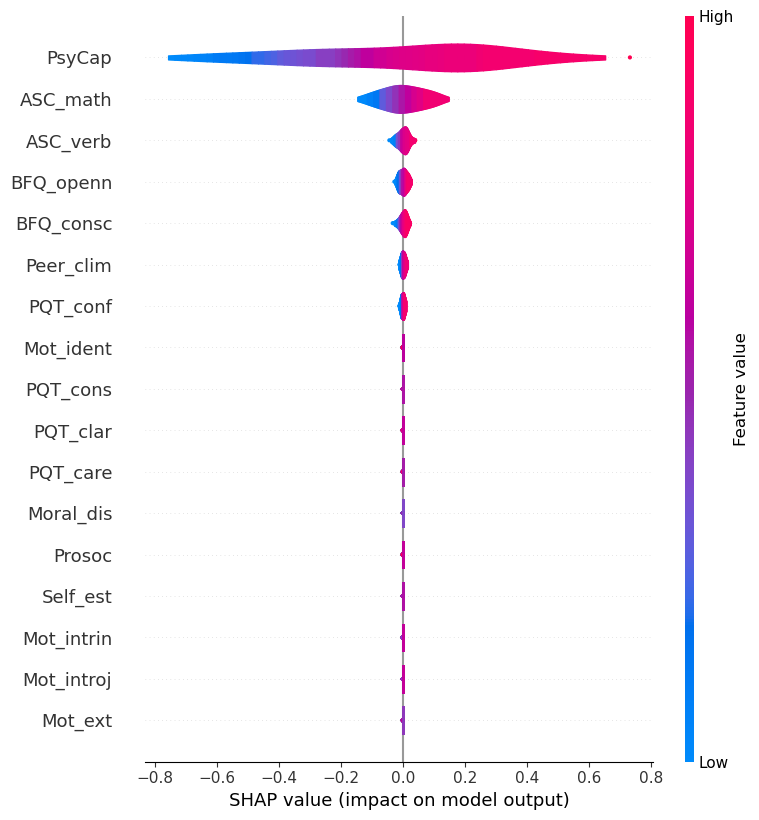

In [61]:
# Fits the explainer (i.e., explain the model's predictions using SHAP)
explainer = shap.Explainer(elastic_tuned.predict, X_test)

# Calculates the SHAP values
shap_values = explainer(X_test)

# Set the figure size
plt.figure(figsize=(4, 3))

# Violin Plot
shap.summary_plot(shap_values,
                  plot_type='violin',
                  feature_names = my_features,
                  show=False)                       # NOTE: if `show = True`, then you cannot export the figure.
                                                    #       Also avoid `plt.show()` for the same reason

# Export figure in png with 300 dpi
# plt.savefig(
#     '../figs_Python/shap_elNet.png',
#     dpi=300,
#     bbox_inches='tight' # bbox_inches='tight' ensures that the entire figure is included in the saved image without any cropping
# )


# INTERPRETATION:
# In the SHAP summary plot, each point represents a SHAP value for a feature and an instance in the dataset.
# Red indicates higher feature values, and blue indicates lower feature values.
# The position on the x-axis shows the SHAP value's impact on the prediction: values to the right increase the prediction, while values to the left decrease the prediction.
# The density of points (shown as the thickness of the violin plot) indicates how often a feature value is observed at different SHAP value levels.

## Random Forest

### Optimization (hyperparameter tuning) with *k*-fold cross-validation

**Hyperparameters in Random Forest**


`n_estimators`      = number of trees in the forest  
`max_features`      = max number of features considered for splitting a node  
`max_depth`         = max number of levels in each decision tree  
`min_samples_split` = min number of data points placed in a node before the node is split  
`min_samples_leaf`  = min number of data points allowed in a leaf node  
`bootstrap`         = method for sampling data points (with or without replacement)

#### Bayesian Optimization (with 5-fold cross validation) 

In [62]:
# Define the parameter search space for Random Forest
param_space = {
    'bootstrap': [True, False],               # Method for sampling data points (with or without replacement)
    'n_estimators': (10, 100),                # Number of trees in the forest
    'max_depth': (1, 10),                     # Maximum depth of each tree
    'min_samples_split': (2, 10),             # Minimum number of samples required to split an internal node
    'min_samples_leaf': (1, 20),              # Minimum number of samples required to be at a leaf node
    'max_features': (1, X_train.shape[1])     # Number of features to consider when looking for the best split
}

# Create a Random Forest regressor
rf = RandomForestRegressor(
    #random_state = 1234
)

# Perform Bayesian Optimization with 5-fold cross-validation
opt = BayesSearchCV(rf,
                    param_space,
                    n_iter=50,
                    cv=5,
                    # random_state=1234,
                    n_jobs=-1)

# Fit the optimization object to the data
opt.fit(X_train, Y_train)

# Print the best hyperparameters found
print("Best hyperparameters:", opt.best_params_)

# Perform cross-validation with the best hyperparameters
# np.random.seed(1234)
cv_results = cross_val_score(opt.best_estimator_,
                             X_train,
                             Y_train,
                             cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_results)
print("Mean cross-validation score:", np.mean(cv_results))

Best hyperparameters: OrderedDict([('bootstrap', True), ('max_depth', 3), ('max_features', 11), ('min_samples_leaf', 4), ('min_samples_split', 3), ('n_estimators', 100)])
Cross-validation scores: [0.58997477 0.56675518 0.62167788 0.63113538 0.48948244]
Mean cross-validation score: 0.5798051297425848


### Train (fit) model and run prediction on train and test data

In [63]:
# Add specified hyperparameters (manually)

rf_tuned = RandomForestRegressor(bootstrap = True,
                                 max_depth = 3,
                                 max_features = 11,
                                 min_samples_leaf = 4,
                                 min_samples_split = 3,
                                 n_estimators = 100
                                # random_state=1234
                                )

# Training
rf_tuned.fit(X_train, Y_train)

# Prediction on train set (useful to subsequently check overfitting)
predict_rf_tuned_train = rf_tuned.predict(X_train)

# Prediction on test set
predict_rf_tuned_test = rf_tuned.predict(X_test)

### Visualization of Observed vs. Predicted Values

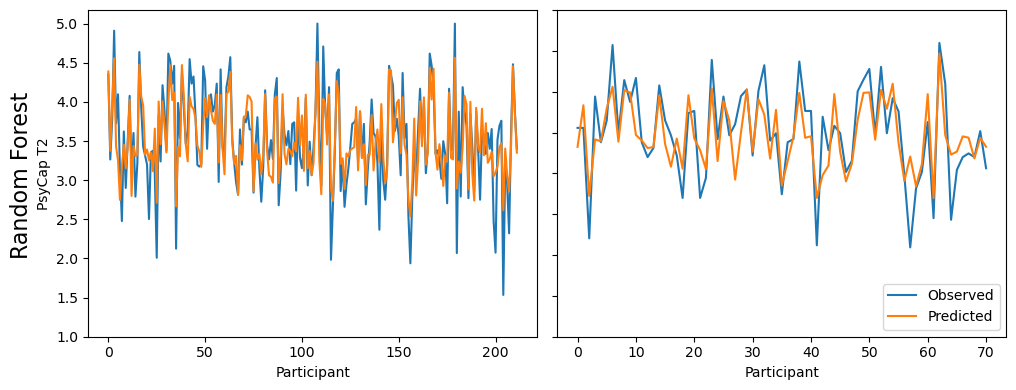

In [64]:
# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first subplot
ax1.plot(Y_train)
ax1.plot(predict_rf_tuned_train)
#ax1.set_title("Train")
ax1.set_xlabel("Participant")
ax1.set_ylabel("PsyCap T2")
ax1.set_yticks(np.arange(1, 5.5, 0.5))
ax1.set_yticklabels([str(x) for x in np.arange(1, 5.5, 0.5)])
#ax1.legend(['observed', 'predicted'])

# Plot the second subplot
ax2.plot(Y_test)
ax2.plot(predict_rf_tuned_test)
#ax2.set_title("Test")
ax2.set_xlabel("Participant")
#ax2.set_ylabel("PsyCap T2")
ax2.set_yticks(np.arange(1, 5.5, 0.5))
#ax2.set_yticklabels([str(x) for x in np.arange(1, 5.5, 0.5)])
ax2.set_yticklabels("")
ax2.legend(['Observed', 'Predicted'], loc='lower right') # Add legend with labels and set location to lower right

# Set a common title for the figure
#fig.suptitle("Prediction for Random Forest")

# Adjust the spacing between subplots
plt.tight_layout()

# Add a vertical suptitle before the y-axis
fig.text(0, 0.55, "Random Forest", va='center', ha='center', rotation='vertical', fontsize=16)

# Store the figure in a variable
pred_obser_values_RandFor = fig

# Show the figure
plt.show()

### Performance

In [65]:
# Compute MAE for the training set (useful to subsequently check overfitting)

mae_rf_train = mean_absolute_error(Y_train, predict_rf_tuned_train)
print(f"MAE for train set (Random Forest): {mae_rf_train:.3f}")

# Compute MAE for test set

mae_rf_test = mean_absolute_error(Y_test, predict_rf_tuned_test)
print(f"MAE for test set (Random Forest): {mae_rf_test:.3f}")


# Compute R^2 for train set (useful to subsequently check overfitting)

r2_rf_train = r2_score(Y_train, predict_rf_tuned_train)
print(f"R^2 for train set (Random Forest): {r2_rf_train:.3f}")

# Compute R^2 for test set

r2_rf_test = r2_score(Y_test, predict_rf_tuned_test)
print(f"R^2 for test set (Random Forest): {r2_rf_test:.3f}")

MAE for train set (Random Forest): 0.258
MAE for test set (Random Forest): 0.273
R^2 for train set (Random Forest): 0.701
R^2 for test set (Random Forest): 0.613


### Check overfitting (evaluating MAE) with a Bootstrap approach

MAE train (Random Forest): 0.280 [0.227-0.342]
MAE test (Random Forest): 0.275 [0.190-0.371]
R^2 train (Random Forest): 0.652 [0.479-0.747]
R^2 test (Random Forest): 0.574 [0.148-0.766]
Figure(640x480)


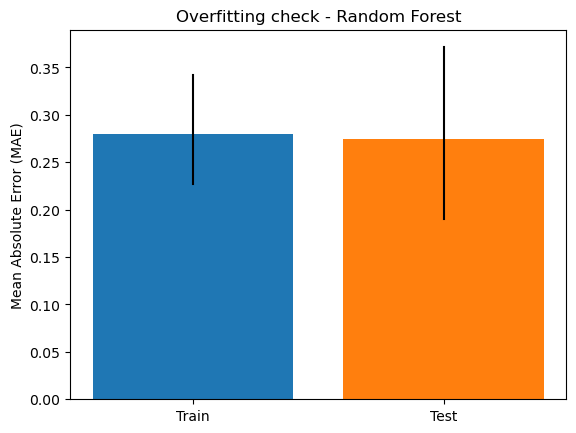

In [66]:
print(
    overf_check(rf_tuned,
                title_overfit = 'Overfitting check - Random Forest',
                my_dpi = 100,
                print_values=True,
                model_name= 'Random Forest')
)

### Feature Importance

In [67]:
# Print values

pd.DataFrame(
        {
            'Features': my_features,
            'Parameters': rf_tuned.feature_importances_
        }
).round(3)

,Features,Parameters
0,ASC_math,0.026
1,ASC_verb,0.006
2,Mot_ext,0.009
3,Mot_introj,0.005
4,Mot_ident,0.002
5,Mot_intrin,0.021
6,Self_est,0.008
7,BFQ_openn,0.059
8,BFQ_consc,0.097
9,Prosoc,0.003


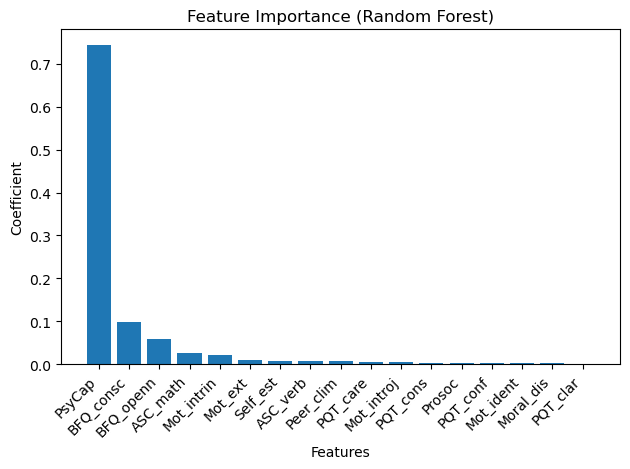

In [68]:
# Visualization of feature importance

coef = rf_tuned.feature_importances_ # in random forest we no longer have `.coef_`, but `.feature_importances_`
df_coef = pd.DataFrame({'feature': my_features, 'coef': coef})
df_coef = df_coef.sort_values('coef', ascending=False)
plt.bar(df_coef['feature'], df_coef['coef'])
plt.xticks(rotation=45, ha='right')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Features")
plt.ylabel("Coefficient")
plt.tight_layout()
plt.show()

### SHAP values

Permutation explainer: 72it [00:45,  1.24it/s]                        


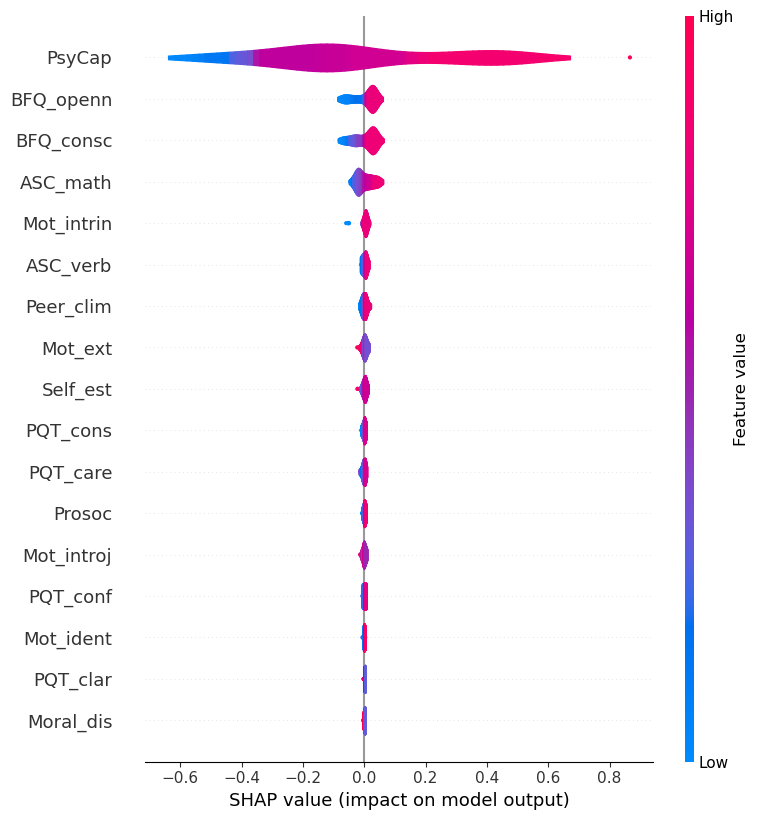

In [69]:
# Fits the explainer (i.e., explain the model's predictions using SHAP)
explainer_rf = shap.Explainer(rf_tuned.predict, X_test)

# Calculates the SHAP values
shap_values_rf = explainer_rf(X_test)

# Set the figure size
plt.figure(figsize=(4, 3))

# Violin plot
shap.summary_plot(shap_values_rf,
                  plot_type='violin',
                  feature_names = my_features,
                  show=False)                       # NOTE: if `show = True`, then you cannot export the figure.
                                                    #       Also avoid `plt.show()` for the same reason
# Export figure in png with 300 dpi
# plt.savefig(
#     '../figs_Python/shap_rf.png',
#     dpi=300,
#     bbox_inches='tight' # bbox_inches='tight' ensures that the entire figure is included in the saved image without any cropping
# )


# INTERPRETATION:
# In the SHAP summary plot, each point represents a SHAP value for a feature and an instance in the dataset.
# Red indicates higher feature values, and blue indicates lower feature values.
# The position on the x-axis shows the SHAP value's impact on the prediction: values to the right increase the prediction, while values to the left decrease the prediction.
# The density of points (shown as the thickness of the violin plot) indicates how often a feature value is observed at different SHAP value levels.